# Tutorial 2: Model-Specific Connectivity

**Duration:** 25-30 minutes  
**Level:** Intermediate  
**Prerequisites:** Tutorial 1, understanding of neural models

## Learning Objectives

By the end of this tutorial, you will:
- Understand the differences between point neuron, population rate, and multi-compartment models
- Create model-specific connectivity patterns
- Build excitatory-inhibitory (E-I) networks
- Apply biological constraints (Dale's principle, degree limits)
- Visualize complex network architectures

## 1. Setup and Imports

In [3]:
import numpy as np
import brainunit as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from braintools.conn import ExcitatoryInhibitory, Random, AxonToDendrite, CompartmentSpecific
from braintools.init import LogNormal, Normal, Uniform, Constant
import braintools.visualize as visualize

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Random seed for reproducibility
rng = np.random.default_rng(42)

print("Environment ready!")

Environment ready!


## 2. Understanding Model Types

### Three Main Categories:

1. **Point Neurons**: Single-compartment integrate-and-fire models
   - Focus: Synaptic connectivity with weights and delays
   - Units: Conductance (nS) for weights, time (ms) for delays
   - Examples: Leaky integrate-and-fire (LIF), Izhikevich

2. **Population Rate Models**: Mean-field population dynamics
   - Focus: Population-to-population coupling
   - Units: Dimensionless coupling strengths
   - Examples: Wilson-Cowan, neural mass models

3. **Multi-Compartment Models**: Detailed morphological neuron models
   - Focus: Compartment-specific targeting
   - Units: Conductance with spatial information
   - Examples: Hodgkin-Huxley with dendrites, pyramidal cells

## 3. Point Neuron Connectivity

Point neurons are the most common model type. Let's explore synaptic connectivity with realistic biological parameters.

### 3.1 Basic Synaptic Connectivity

In [4]:
# Create a realistic synaptic connectivity pattern
# Using log-normal weight distribution (typical for cortical synapses)

synaptic_conn = Random(
    prob=0.1,
    weight=LogNormal(
        mean=1.0 * u.nS,
        std=0.5 * u.nS
    ),
    delay=Normal(
        mean=1.5 * u.ms,
        std=0.3 * u.ms,
    ).clip(min_val=0.1 * u.ms),
    allow_self_connections=False,
    seed=42
)

# Generate connections
result = synaptic_conn(pre_size=200, post_size=200, rng=rng)

print(f"Point Neuron Network:")
print(f"  Neurons: 200 × 200")
print(f"  Connections: {result.n_connections}")
print(f"  Mean weight: {result.weights.mean():.3f}")
print(f"  Mean delay: {result.delays.mean():.3f}")

Point Neuron Network:
  Neurons: 200 × 200
  Connections: 3999
  Mean weight: 0.989 * nsiemens
  Mean delay: 1.499 * msecond


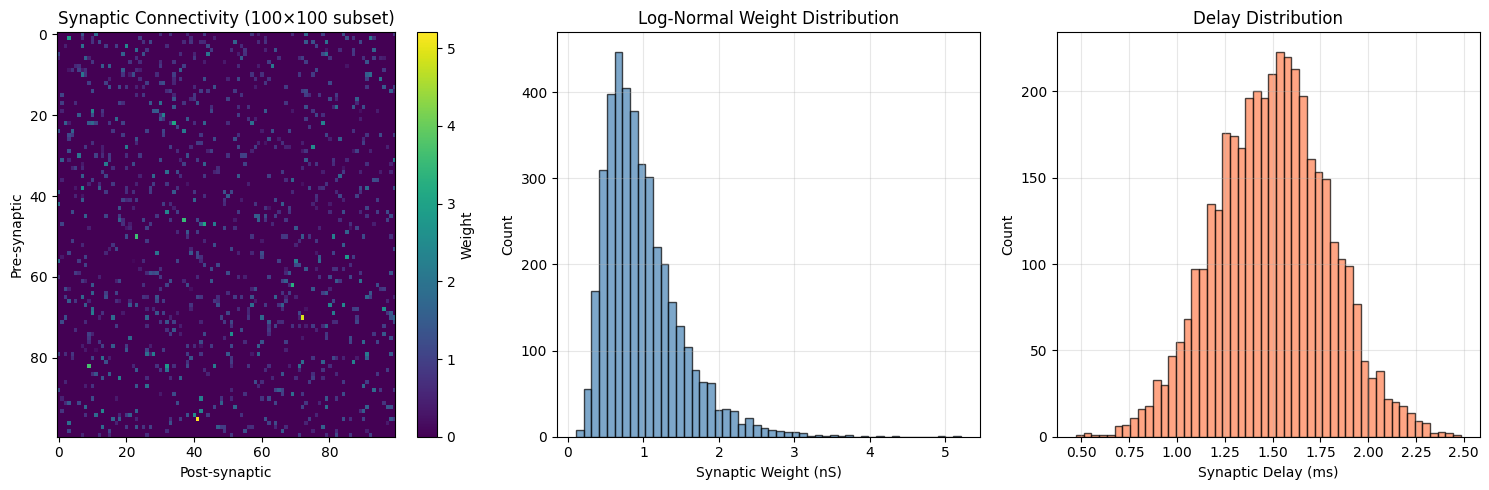

In [5]:
# Visualize the connectivity
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, figure=fig)

# Connectivity matrix (subset)
ax1 = fig.add_subplot(gs[0, 0])
subset = result.weight2dense()[:100, :100]
visualize.connectivity_matrix(
    u.get_mantissa(subset),
    cmap='viridis',
    center_zero=False,
    ax=ax1,
    show_colorbar=True,
    title='Synaptic Connectivity (100×100 subset)'
)

# Weight distribution
ax2 = fig.add_subplot(gs[0, 1])
weights_np = result.weights.to(u.nS).mantissa
ax2.hist(weights_np, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Synaptic Weight (nS)')
ax2.set_ylabel('Count')
ax2.set_title('Log-Normal Weight Distribution')
ax2.grid(True, alpha=0.3)

# Delay distribution
ax3 = fig.add_subplot(gs[0, 2])
delays_np = result.delays.to(u.ms).mantissa
ax3.hist(delays_np, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Synaptic Delay (ms)')
ax3.set_ylabel('Count')
ax3.set_title('Delay Distribution')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Multiple Receptor Types

Real neurons have multiple types of synaptic receptors (AMPA, NMDA, GABA, etc.). Let's model this:

In [6]:
# AMPA receptors: Fast excitatory
ampa_conn = Random(
    prob=0.08,
    weight=LogNormal(mean=0.8 * u.nS, std=0.2 * u.nS),
    delay=Uniform(low=0.5 * u.ms, high=1.5 * u.ms),
    seed=42
)(pre_size=100, post_size=100, rng=rng)

# NMDA receptors: Slow excitatory
nmda_conn = Random(
    prob=0.05,
    weight=LogNormal(mean=0.3 * u.nS, std=0.1 * u.nS),
    delay=Uniform(low=1.0 * u.ms, high=2.0 * u.ms),
    seed=43
)(pre_size=100, post_size=100, rng=rng)

# GABA receptors: Inhibitory
gaba_conn = Random(
    prob=0.12,
    weight=LogNormal(mean=1.2 * u.nS, std=0.4 * u.nS),
    delay=Uniform(low=0.3 * u.ms, high=0.8 * u.ms),
    seed=44
)(pre_size=100, post_size=100, rng=rng)

print("Multi-Receptor Network:")
print(f"  AMPA connections: {ampa_conn.n_connections}")
print(f"  NMDA connections: {nmda_conn.n_connections}")
print(f"  GABA connections: {gaba_conn.n_connections}")
print(f"  Total connections: {ampa_conn.n_connections + nmda_conn.n_connections + gaba_conn.n_connections}")

Multi-Receptor Network:
  AMPA connections: 820
  NMDA connections: 496
  GABA connections: 1150
  Total connections: 2466


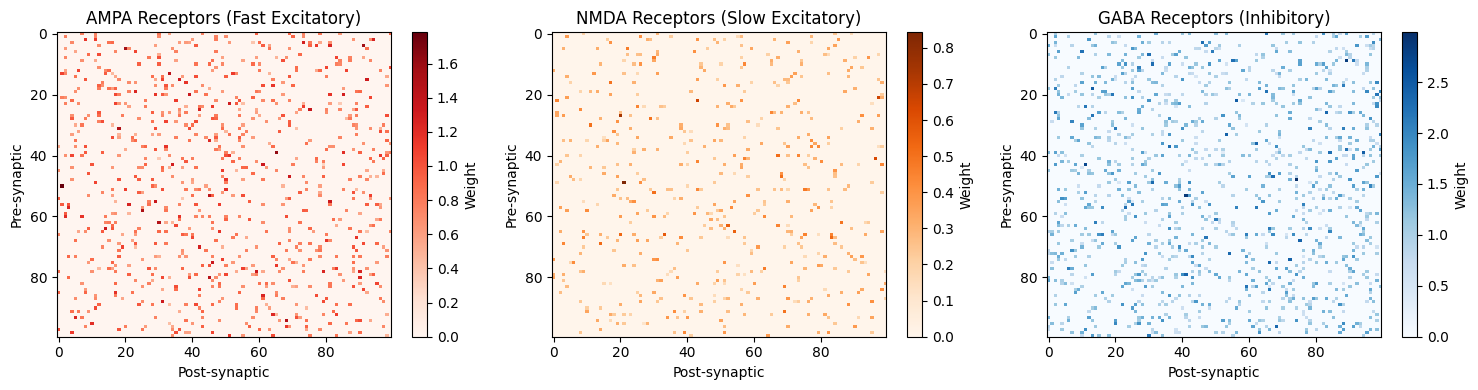

In [7]:
# Visualize all three receptor types
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

visualize.connectivity_matrix(
    u.get_magnitude(ampa_conn.weight2dense()),
    cmap='Reds',
    center_zero=False,
    ax=axes[0],
    show_colorbar=True,
    title='AMPA Receptors (Fast Excitatory)'
)

visualize.connectivity_matrix(
    u.get_mantissa(nmda_conn.weight2dense()),
    cmap='Oranges',
    center_zero=False,
    ax=axes[1],
    show_colorbar=True,
    title='NMDA Receptors (Slow Excitatory)'
)

visualize.connectivity_matrix(
    u.get_magnitude(gaba_conn.weight2dense()),
    cmap='Blues',
    center_zero=False,
    ax=axes[2],
    show_colorbar=True,
    title='GABA Receptors (Inhibitory)'
)

plt.tight_layout()
plt.show()

## 4. Excitatory-Inhibitory Networks

One of the most important network architectures in neuroscience is the balanced E-I network. Let's build a realistic one following cortical proportions (80% excitatory, 20% inhibitory).

### 4.1 Dale's Principle

Dale's principle states that a neuron releases the same neurotransmitter at all of its synapses. This means:
- Excitatory neurons have only positive (excitatory) outgoing connections
- Inhibitory neurons have only negative (inhibitory) outgoing connections

In [8]:
# Network parameters
n_total = 500
n_exc = int(0.8 * n_total)  # 400 excitatory
n_inh = int(0.2 * n_total)  # 100 inhibitory

print(f"E-I Network Configuration:")
print(f"  Total neurons: {n_total}")
print(f"  Excitatory (E): {n_exc} (80%)")
print(f"  Inhibitory (I): {n_inh} (20%)")
print(f"  E:I ratio = {n_exc/n_inh:.1f}:1")

E-I Network Configuration:
  Total neurons: 500
  Excitatory (E): 400 (80%)
  Inhibitory (I): 100 (20%)
  E:I ratio = 4.0:1


In [9]:
# Use the built-in ExcitatoryInhibitory pattern
ei_network = ExcitatoryInhibitory(
    exc_ratio=0.8,
    exc_prob=0.1,      # E→E and E→I
    inh_prob=0.2,      # I→E and I→I  (higher for stronger inhibition)
    exc_weight=LogNormal(mean=1.0 * u.nS, std=0.3 * u.nS),
    inh_weight=LogNormal(mean=2.5 * u.nS, std=0.8 * u.nS),  # Stronger inhibition
    delay=Uniform(low=0.5 * u.ms, high=2.0 * u.ms),
    # inh_delay=Uniform(low=0.3 * u.ms, high=1.0 * u.ms),  # Faster inhibition
    seed=42
)

ei_result = ei_network(pre_size=n_total, post_size=n_total, rng=rng)

print(f"\nE-I Network Connectivity:")
print(f"  Total connections: {ei_result.n_connections}")
print(f"  Expected E connections: ~{int(n_exc * n_total * 0.1)}")
print(f"  Expected I connections: ~{int(n_inh * n_total * 0.2)}")


E-I Network Connectivity:
  Total connections: 30028
  Expected E connections: ~20000
  Expected I connections: ~10000


In [10]:
# Analyze the E-I connectivity
dense_matrix = ei_result.weight2dense()

# Separate E and I weights
exc_mask = ei_result.pre_indices < n_exc
inh_mask = ei_result.pre_indices >= n_exc

exc_weights = ei_result.weights[exc_mask].to(u.nS).mantissa
inh_weights = ei_result.weights[inh_mask].to(u.nS).mantissa

print(f"Excitatory connections: {len(exc_weights)}")
print(f"  Mean weight: {exc_weights.mean():.3f} nS")
print(f"  Std weight: {exc_weights.std():.3f} nS")

print(f"\nInhibitory connections: {len(inh_weights)}")
print(f"  Mean weight: {inh_weights.mean():.3f} nS")
print(f"  Std weight: {inh_weights.std():.3f} nS")

Excitatory connections: 20020
  Mean weight: 0.998 nS
  Std weight: 0.300 nS

Inhibitory connections: 10008
  Mean weight: 2.504 nS
  Std weight: 0.797 nS


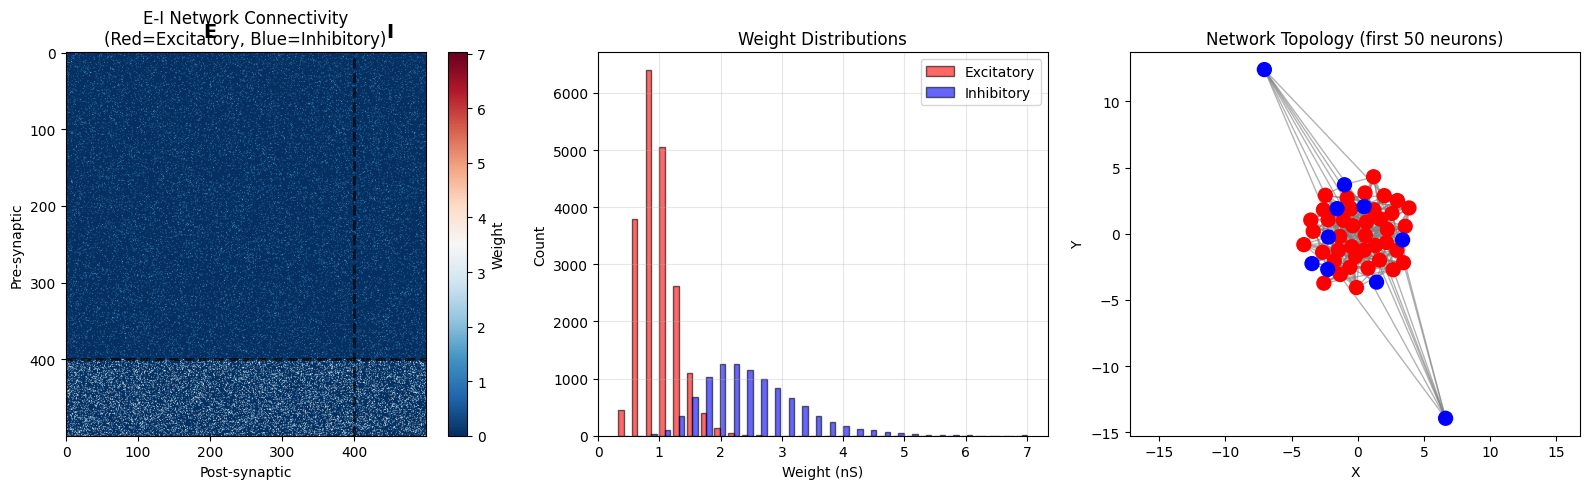

In [11]:
# Visualize E-I network
fig = plt.figure(figsize=(16, 5))
gs = GridSpec(1, 3, figure=fig)

# Full connectivity matrix
ax1 = fig.add_subplot(gs[0, 0])
visualize.connectivity_matrix(
    u.get_magnitude(dense_matrix),
    cmap='RdBu_r',
    center_zero=False,
    ax=ax1,
    show_colorbar=True,
    title='E-I Network Connectivity\n(Red=Excitatory, Blue=Inhibitory)'
)
ax1.axhline(y=n_exc, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(x=n_exc, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(n_exc/2, -20, 'E', ha='center', fontsize=14, fontweight='bold')
ax1.text(n_exc + n_inh/2, -20, 'I', ha='center', fontsize=14, fontweight='bold')

# Weight distributions
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist([exc_weights, inh_weights], bins=30, label=['Excitatory', 'Inhibitory'],
         color=['red', 'blue'], alpha=0.6, edgecolor='black')
ax2.set_xlabel('Weight (nS)')
ax2.set_ylabel('Count')
ax2.set_title('Weight Distributions')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Network topology (small subset)
ax3 = fig.add_subplot(gs[0, 2])
subset_size = 50
subset_adj = dense_matrix[:subset_size, :subset_size]
node_colors = ['red' if i < int(0.8*subset_size) else 'blue' for i in range(subset_size)]
visualize.network_topology(
    u.get_magnitude(subset_adj),
    layout='spring',
    node_colors=node_colors,
    ax=ax3,
    title=f'Network Topology (first {subset_size} neurons)'
)

plt.tight_layout()
plt.show()

### 4.2 Connection Type Analysis

In E-I networks, we have four types of connections:
- E → E (recurrent excitation)
- E → I (feedforward excitation)
- I → E (feedback inhibition)
- I → I (lateral inhibition)

In [12]:
# Analyze connection types
ee_mask = (ei_result.pre_indices < n_exc) & (ei_result.post_indices < n_exc)
ei_mask = (ei_result.pre_indices < n_exc) & (ei_result.post_indices >= n_exc)
ie_mask = (ei_result.pre_indices >= n_exc) & (ei_result.post_indices < n_exc)
ii_mask = (ei_result.pre_indices >= n_exc) & (ei_result.post_indices >= n_exc)

print("Connection Type Breakdown:")
print(f"  E → E: {ee_mask.sum()} connections")
print(f"  E → I: {ei_mask.sum()} connections")
print(f"  I → E: {ie_mask.sum()} connections")
print(f"  I → I: {ii_mask.sum()} connections")
print(f"\n  Total: {ee_mask.sum() + ei_mask.sum() + ie_mask.sum() + ii_mask.sum()}")

Connection Type Breakdown:
  E → E: 16001 connections
  E → I: 4019 connections
  I → E: 8067 connections
  I → I: 1941 connections

  Total: 30028


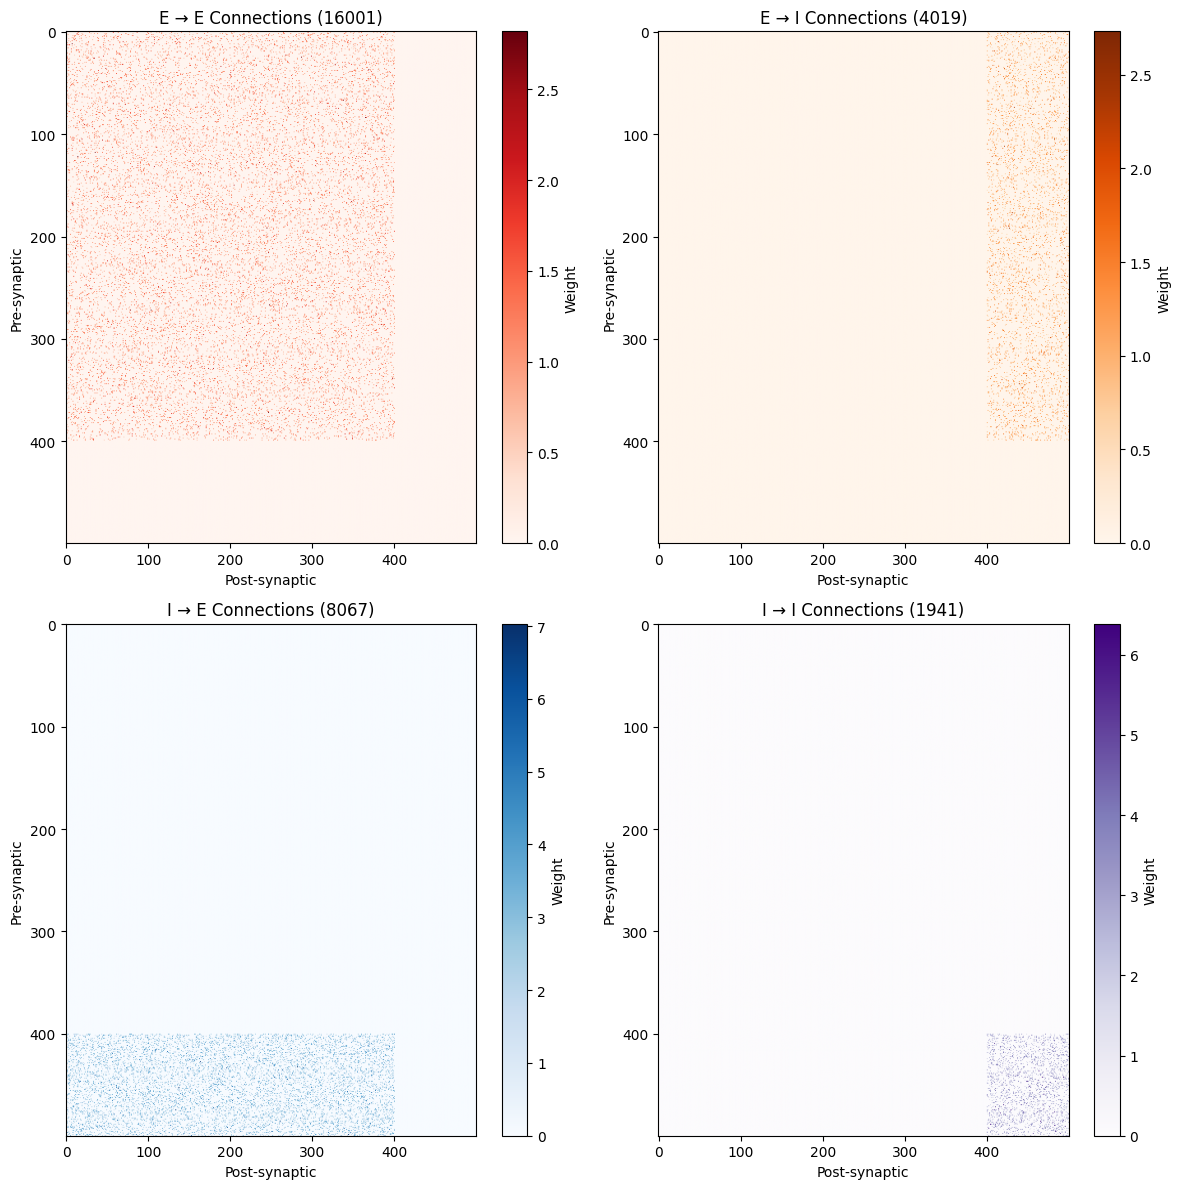

In [13]:
# Visualize the four connection types separately
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# E → E
dense_matrix = u.get_magnitude(dense_matrix)
ee_matrix = np.zeros_like(dense_matrix)
ee_matrix[:n_exc, :n_exc] = dense_matrix[:n_exc, :n_exc]
visualize.connectivity_matrix(
    ee_matrix,
    cmap='Reds',
    center_zero=False,
    ax=axes[0, 0],
    title=f'E → E Connections ({ee_mask.sum()})'
)

# E → I
ei_matrix = np.zeros_like(dense_matrix)
ei_matrix[:n_exc, n_exc:] = dense_matrix[:n_exc, n_exc:]
visualize.connectivity_matrix(
    ei_matrix,
    cmap='Oranges',
    center_zero=False,
    ax=axes[0, 1],
    title=f'E → I Connections ({ei_mask.sum()})'
)

# I → E
ie_matrix = np.zeros_like(dense_matrix)
ie_matrix[n_exc:, :n_exc] = dense_matrix[n_exc:, :n_exc]
visualize.connectivity_matrix(
    ie_matrix,
    cmap='Blues',
    center_zero=False,
    ax=axes[1, 0],
    title=f'I → E Connections ({ie_mask.sum()})'
)

# I → I
ii_matrix = np.zeros_like(dense_matrix)
ii_matrix[n_exc:, n_exc:] = dense_matrix[n_exc:, n_exc:]
visualize.connectivity_matrix(
    ii_matrix,
    cmap='Purples',
    center_zero=False,
    ax=axes[1, 1],
    title=f'I → I Connections ({ii_mask.sum()})'
)

plt.tight_layout()
plt.show()

## 5. Multi-Compartment Model Connectivity

Multi-compartment models include detailed neuronal morphology. Synapses can target specific compartments (soma, proximal dendrites, distal dendrites, etc.).

### 5.1 Compartment Types

Standard compartment types:
- **SOMA** (0): Cell body
- **BASAL_DENDRITE** (1): Dendrites near soma
- **APICAL_DENDRITE** (2): Main dendritic trunk
- **AXON** (3): Axon hillock and initial segment

In [14]:
# Axon-to-dendrite connectivity (most common)
axon_dend = AxonToDendrite(
    connection_prob=0.15,
    weight=LogNormal(mean=2.0 * u.nS, std=0.6 * u.nS),
    delay=Uniform(low=0.5 * u.ms, high=2.0 * u.ms),
    seed=42
)

comp_result = axon_dend(
    pre_size=100,
    post_size=100,
    rng=rng
)

print("Multi-Compartment Network:")
print(f"  Neurons: 100 → 100")
print(f"  Pattern: Axon → Dendrite")
print(f"  Connections: {comp_result.n_connections}")
print(f"  Mean weight: {comp_result.weights.mean():.3f}")

Multi-Compartment Network:
  Neurons: 100 → 100
  Pattern: Axon → Dendrite
  Connections: 3010
  Mean weight: 2.015 * nsiemens


### 5.2 Compartment-Specific Targeting

Different interneuron types target different compartments:
- **Basket cells** → Soma (perisomatic inhibition)
- **Chandelier cells** → Axon initial segment
- **Martinotti cells** → Distal apical dendrites

In [15]:
from braintools.conn import SOMA, BASAL_DENDRITE, APICAL_DENDRITE, AXON

# Basket cell connectivity: Axon → Soma
basket_cell = CompartmentSpecific(
    compartment_mapping={AXON: [SOMA]},
    connection_prob=0.2,
    weight=LogNormal(mean=3.0 * u.nS, std=0.8 * u.nS),  # Strong inhibition
    seed=42
)

basket_result = basket_cell(pre_size=50, post_size=50, rng=rng)

print("Basket Cell Connectivity:")
print(f"  Type: Axon → Soma (perisomatic inhibition)")
print(f"  Connections: {basket_result.n_connections}")
print(f"  Mean weight: {basket_result.weights.mean():.3f}")

Basket Cell Connectivity:
  Type: Axon → Soma (perisomatic inhibition)
  Connections: 524
  Mean weight: 2.993 * nsiemens


In [16]:
# Martinotti cell connectivity: Axon → Apical Dendrite
martinotti_cell = CompartmentSpecific(
    compartment_mapping={AXON: [APICAL_DENDRITE]},
    connection_prob=0.15,
    weight=LogNormal(mean=1.5 * u.nS, std=0.4 * u.nS),
    seed=43
)

martinotti_result = martinotti_cell(pre_size=50, post_size=50, rng=rng)

print("\nMartinotti Cell Connectivity:")
print(f"  Type: Axon → Apical Dendrite (dendritic inhibition)")
print(f"  Connections: {martinotti_result.n_connections}")
print(f"  Mean weight: {martinotti_result.weights.mean():.3f}")


Martinotti Cell Connectivity:
  Type: Axon → Apical Dendrite (dendritic inhibition)
  Connections: 351
  Mean weight: 1.487 * nsiemens


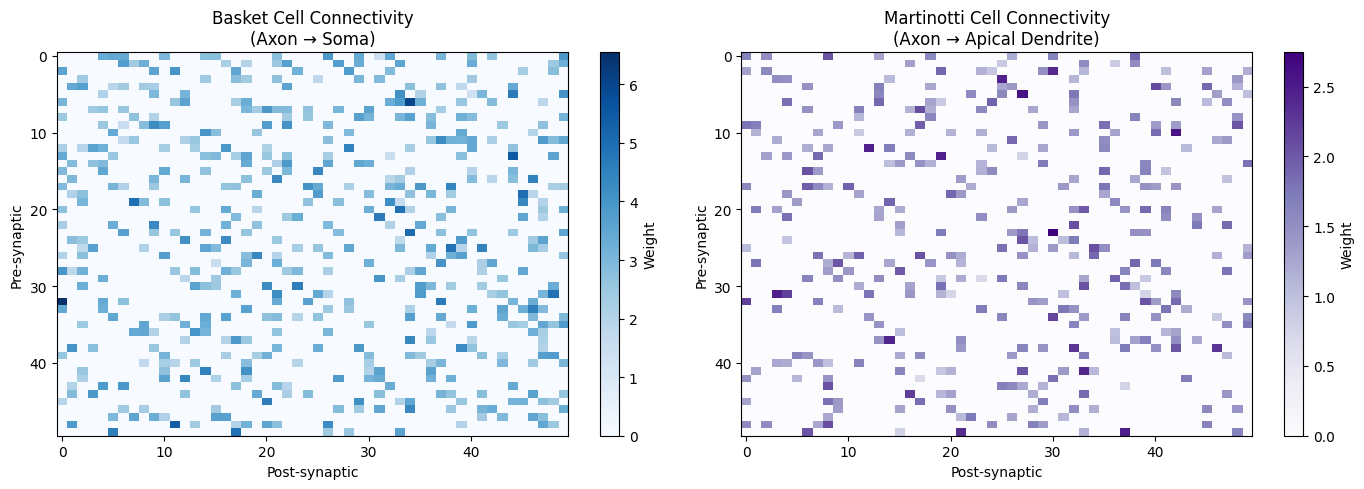

In [17]:
# Visualize compartment-specific connectivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

visualize.connectivity_matrix(
    u.get_mantissa(basket_result.weight2dense()),
    cmap='Blues',
    center_zero=False,
    ax=axes[0],
    show_colorbar=True,
    title='Basket Cell Connectivity\n(Axon → Soma)'
)

visualize.connectivity_matrix(
    u.get_magnitude(martinotti_result.weight2dense()),
    cmap='Purples',
    center_zero=False,
    ax=axes[1],
    show_colorbar=True,
    title='Martinotti Cell Connectivity\n(Axon → Apical Dendrite)'
)

plt.tight_layout()
plt.show()

## 6. Biological Constraints

Real neural networks have various biological constraints that shape connectivity.

### 6.1 Degree Constraints

Neurons have limits on how many connections they can make and receive.

In [18]:
# Create random connectivity with degree limits
unconstrained = Random(
    prob=0.2,
    weight=Constant(1.0 * u.nS),
    seed=42
)(pre_size=200, post_size=200, rng=rng)

# Apply degree constraints
constrained = Random(
    prob=0.2,
    weight=Constant(1.0 * u.nS),
    seed=42
)(pre_size=200, post_size=200, rng=rng)

# Note: Degree constraints would typically be applied as a post-processing step
# For this example, we'll analyze the degree distributions

in_degrees = np.bincount(unconstrained.post_indices, minlength=200)
out_degrees = np.bincount(unconstrained.pre_indices, minlength=200)

print("Degree Statistics:")
print(f"  In-degree: mean={in_degrees.mean():.1f}, max={in_degrees.max()}, std={in_degrees.std():.1f}")
print(f"  Out-degree: mean={out_degrees.mean():.1f}, max={out_degrees.max()}, std={out_degrees.std():.1f}")

Degree Statistics:
  In-degree: mean=39.6, max=57, std=6.2
  Out-degree: mean=39.6, max=56, std=5.3


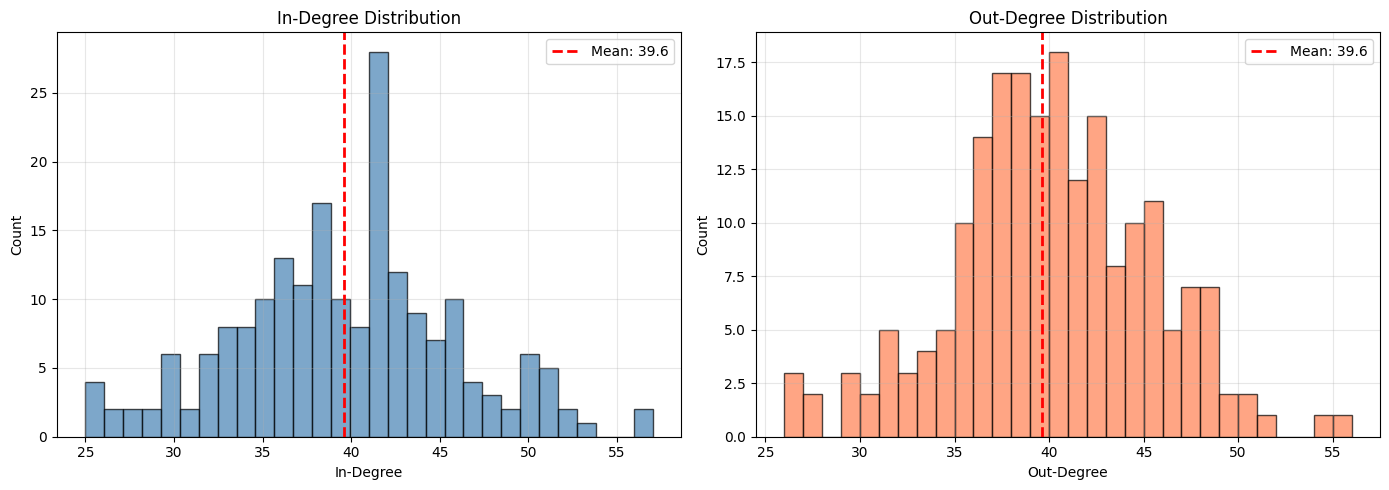

In [19]:
# Visualize degree distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(in_degrees, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(in_degrees.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {in_degrees.mean():.1f}')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Count')
axes[0].set_title('In-Degree Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(out_degrees, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(out_degrees.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {out_degrees.mean():.1f}')
axes[1].set_xlabel('Out-Degree')
axes[1].set_ylabel('Count')
axes[1].set_title('Out-Degree Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Example Project: Balanced E-I Network with Multiple Receptor Types

Let's combine everything we've learned to build a realistic cortical network.

In [21]:
# Network parameters
N_total = 1000
N_exc = 800
N_inh = 200

print("Building Realistic Cortical Network...")
print(f"  Total neurons: {N_total}")
print(f"  Excitatory: {N_exc} ({N_exc/N_total*100:.0f}%)")
print(f"  Inhibitory: {N_inh} ({N_inh/N_total*100:.0f}%)")

# Build the network using ExcitatoryInhibitory pattern
realistic_network = ExcitatoryInhibitory(
    exc_ratio=0.8,
    exc_prob=0.05,  # Sparse connectivity
    inh_prob=0.15,  # Denser inhibitory connectivity
    exc_weight=LogNormal(mean=0.8 * u.nS, std=0.3 * u.nS),
    inh_weight=LogNormal(mean=2.0 * u.nS, std=0.6 * u.nS),
    # exc_delay=Normal(mean=1.5 * u.ms, std=0.3 * u.ms, min_delay=0.1 * u.ms),
    delay=Normal(mean=0.8 * u.ms, std=0.2 * u.ms).clip(min_val=0.1 * u.ms),
    seed=42
)

realistic_result = realistic_network(pre_size=N_total, post_size=N_total, rng=rng)

print(f"\nNetwork Statistics:")
print(f"  Total connections: {realistic_result.n_connections}")
print(f"  Sparsity: {1 - realistic_result.n_connections/(N_total*N_total):.2%}")

# Analyze by type
exc_conns = realistic_result.pre_indices < N_exc
inh_conns = realistic_result.pre_indices >= N_exc
print(f"\n  Excitatory connections: {exc_conns.sum()}")
print(f"  Inhibitory connections: {inh_conns.sum()}")
print(f"  E:I connection ratio: {exc_conns.sum()/inh_conns.sum():.2f}")

Building Realistic Cortical Network...
  Total neurons: 1000
  Excitatory: 800 (80%)
  Inhibitory: 200 (20%)

Network Statistics:
  Total connections: 69518
  Sparsity: 93.05%

  Excitatory connections: 39608
  Inhibitory connections: 29910
  E:I connection ratio: 1.32


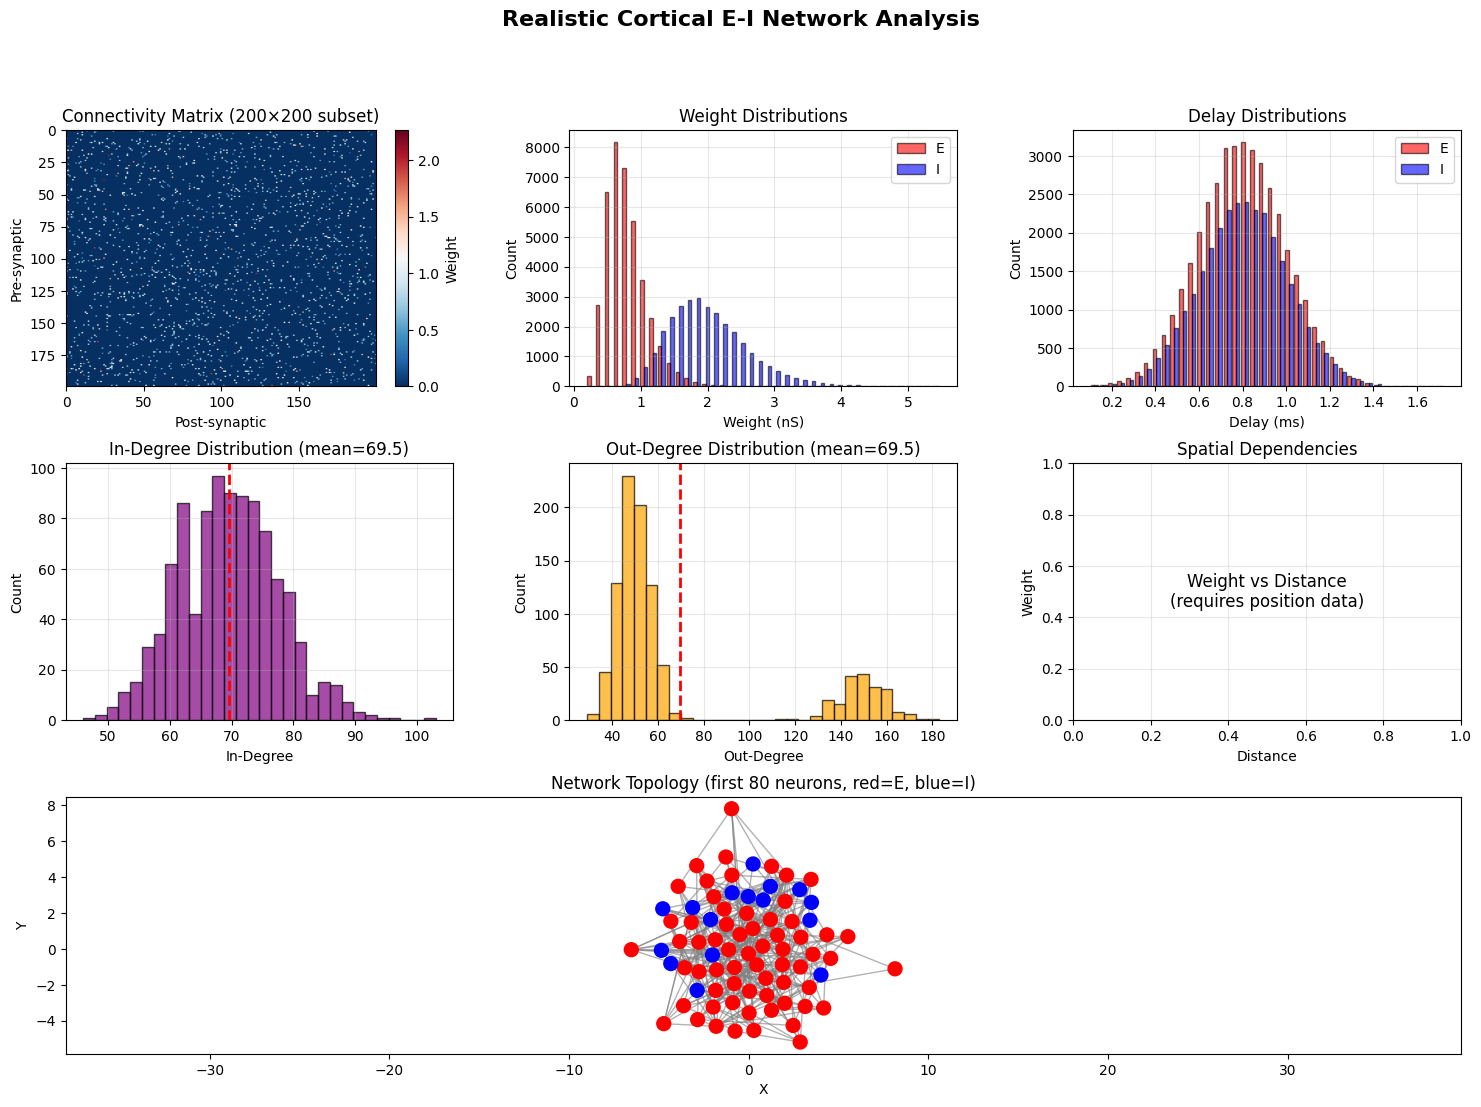

In [22]:
# Comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Full connectivity matrix (subset)
ax1 = fig.add_subplot(gs[0, 0])
subset_size = 200
subset_matrix = realistic_result.weight2dense()[:subset_size, :subset_size]
visualize.connectivity_matrix(
    u.get_magnitude(subset_matrix),
    cmap='RdBu_r',
    center_zero=False,
    ax=ax1,
    title=f'Connectivity Matrix ({subset_size}×{subset_size} subset)'
)

# 2. Weight distributions
ax2 = fig.add_subplot(gs[0, 1])
exc_w = realistic_result.weights[exc_conns].to(u.nS).mantissa
inh_w = realistic_result.weights[inh_conns].to(u.nS).mantissa
ax2.hist([exc_w, inh_w], bins=40, label=['E', 'I'],
         color=['red', 'blue'], alpha=0.6, edgecolor='black')
ax2.set_xlabel('Weight (nS)')
ax2.set_ylabel('Count')
ax2.set_title('Weight Distributions')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Delay distributions  
ax3 = fig.add_subplot(gs[0, 2])
exc_d = realistic_result.delays[exc_conns].to(u.ms).mantissa
inh_d = realistic_result.delays[inh_conns].to(u.ms).mantissa
ax3.hist([exc_d, inh_d], bins=40, label=['E', 'I'],
         color=['red', 'blue'], alpha=0.6, edgecolor='black')
ax3.set_xlabel('Delay (ms)')
ax3.set_ylabel('Count')
ax3.set_title('Delay Distributions')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. In-degree distribution
ax4 = fig.add_subplot(gs[1, 0])
in_deg = np.bincount(realistic_result.post_indices, minlength=N_total)
ax4.hist(in_deg, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(in_deg.mean(), color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('In-Degree')
ax4.set_ylabel('Count')
ax4.set_title(f'In-Degree Distribution (mean={in_deg.mean():.1f})')
ax4.grid(True, alpha=0.3)

# 5. Out-degree distribution
ax5 = fig.add_subplot(gs[1, 1])
out_deg = np.bincount(realistic_result.pre_indices, minlength=N_total)
ax5.hist(out_deg, bins=30, color='orange', alpha=0.7, edgecolor='black')
ax5.axvline(out_deg.mean(), color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Out-Degree')
ax5.set_ylabel('Count')
ax5.set_title(f'Out-Degree Distribution (mean={out_deg.mean():.1f})')
ax5.grid(True, alpha=0.3)

# 6. Weight vs Distance scatter (if positions available)
ax6 = fig.add_subplot(gs[1, 2])
ax6.text(0.5, 0.5, 'Weight vs Distance\n(requires position data)',
         ha='center', va='center', fontsize=12, transform=ax6.transAxes)
ax6.set_xlabel('Distance')
ax6.set_ylabel('Weight')
ax6.set_title('Spatial Dependencies')
ax6.grid(True, alpha=0.3)

# 7. Network topology (small subset)
ax7 = fig.add_subplot(gs[2, :])
topo_size = 80
topo_matrix = realistic_result.weight2dense()[:topo_size, :topo_size]
topo_colors = ['red' if i < int(0.8*topo_size) else 'blue' for i in range(topo_size)]
visualize.network_topology(
    u.get_magnitude(topo_matrix),
    layout='spring',
    node_colors=topo_colors,
    ax=ax7,
    title=f'Network Topology (first {topo_size} neurons, red=E, blue=I)'
)

plt.suptitle('Realistic Cortical E-I Network Analysis', fontsize=16, fontweight='bold')
plt.show()